# Data processing

TODO:

- TIKTOKEN - ESTIMATE TOKENS
- Replicate setup

DONE: 

- Compute T_Human (time per question)
- SQRT scaling (instead of linear)
- 'is_multiple_answer' == False
- Estimate upper bound:
    - 10 Qs around 90% max T_human
    - 10 Models from METR & openrouter.ai (LOCAL VS API)
- Improve heuristics -> Ascending Difficulty order in EGMO & RMM ( PENDING )

MODELS:

- GPT-3 (May 2020) [METR] [API]
- GPT-3.5 (March 2022) [METR] [API]
- GPT-4 (March 2023) [METR] [AGENT] [API]
- Claude 3.5 Sonnet (Old) (June 2024) [METR] [AGENT] [API]
- Llama 3.2 (September 2024) [FREE] [AGENT] [LOCAL/API]
- Llama 3.3 (December 2024) [FREE] [AGENT] [LOCAL/API]
- Claude 3.7 Sonnet (Feb 2025) [METR] [AGENT] [API]
- Llama 4 (April 2025) [FREE] [AGENT] [LOCAL/API]
- Claude Sonnet 4 (May 2025) [METR] [AGENT] [API]
- GPT-5 (August 2025) [METR] [AGENT]

In [1]:
import os
import json
import math
from collections import Counter, defaultdict
from typing import List, Dict, Any, Tuple
import pandas as pd
import numpy as np

# ------------------- CONFIG -------------------
FILES = {
    "Chinese_Olympiad_Mathematics": "Chinese_Olympiad_Mathematics.json",
    "English_Olympiad_Mathematics": "English_Olympiad_Mathematics.json",
    "English_Olympiad_Physics": "English_Olympiad_Physics.json",
    "Gaokao_Maths": "Gaokao_Maths.json",
    "Gaokao_Physics": "Gaokao_Physics.json",
}

# Make pandas print all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Contest → (total_minutes, problems)
CONTEST_RULES = {

    # Shortlist —a much larger set of candidate problems prepared for the Jury. NO SUBPROBLEMS.
    # Each q is about 90 minutes, adjust that number
    "IMO": (270, 3),  # Rules -> https://www.imo-official.org/documents/RegulationsIMO.pdf ( 5. Contest Regulations )

    # Exact Exams, 1 or 2 subquestions
    # Divide exam qs by total time and adjust
    "EGMO": (270, np.nan), # Rules -> https://www.egmo.org/egmos/egmo14/regulations/ 
    "RMM": (270, np.nan),  # Rules -> https://rmms.lbi.ro/rmm2024/_dwl/regulation_master2024.pdf

    # Two versions per year, multiple subquestions
    # Divide exam qs by total time and adjust
    "EMC": (240 * 2, np.nan),  # Rules -> https://emc.mnm.hr/competition/rules/ 

    # Only one version per year, multiple subquestions
    # Divide exam qs by total time and adjust
    "ARML": (186, np.nan), # Rules -> https://www.arml.com/ARML/arml_2019/page/index.php?page_type=public&page=competition_rules | https://mathleague.org/arml.php 

# DIFFERENT DATASET ------

    # Gaokao Math - Many questions from mock exams (more than 1)
    # Each q is about 5 minutes, adjust that number
    "Gaokao": (120, 24), # Rules -> https://gaokao.chsi.com.cn/gkxx/zc/ss/202401/20240129/2293250176.html
}

### EGMO EXAMS -> Sorted by ascending difficulty

- EGMO/2021 = 562,563,564
- EGMO/2021-2 = 565,566,567
- EGMO/2017 = 568,569,570
- EGMO/2017-2 = 571,572,573,574
- EGMO/2016 = 575,576,577
- EGMO/2016-2 = 578,579,580
- EGMO/2020 = 583,584,585
- EGMO/2018 = 586,587,588,589,590
- EGMO/2018-2 = 591,592,593,594
- EGMO/2019 = 595,596,597
- EGMO/2019-2 = 598,599,600
- EGMO/2022 = 601,602.603
- EGMO/2022-2 = 604,605,606
- EGMO/2013 = 607,608,609,610
- EGMO/2013-2 = 611,612,613
- EGMO/2015 = 614,615,616
- EGMO/2015-2 = 617,618,619
- EGMO/2023 = 620,621,622
- EGMO/2023-2 = 623,624,625

### RMM EXAMS -> Sorted by ascending difficulty

- RMM/2013 = 0,1,2
- RMM/2021 = 3,4,5
- RMM/2021-2 = 26,27,28
- RMM/2015 = 6,7,8
- RMM/2015-2 = 32,33,34
- RMM/2017 = 9,10,11,12
- RMM/2017-2 = 35,36,37
- RMM/2023 = 13,14,15
- RMM/2023-2 = 16,17,18
- RMM/2016 = 19,20,21,22
- RMM/2016-2 = 41,42,43
- RMM/2011 = 23,24,25
- RMM/2011-2 = 47,48,49
- RMM/2018 = 38,39,40
- RMM/2018-2 = 50,51,52
- RMM/2019 = 44,45,46

## Eng Math Olympiad

In [3]:
path = FILES["English_Olympiad_Mathematics"]

data_df = pd.read_json(path)

print("Exam Sources:")
print( data_df['source'].unique() )

Exam Sources:
['RMM/2013' 'RMM/2021' 'RMM/2015' 'RMM/2017' 'RMM/2023' 'RMM/2016'
 'RMM/2011' 'RMM/2018' 'RMM/2019' 'IMO/2007' 'IMO/2011' 'IMO/2010'
 'IMO/2006' 'IMO/2021' 'IMO/2017' 'IMO/2016' 'IMO/2020' 'IMO/2019'
 'IMO/2015' 'IMO/2014' 'IMO/2022' 'IMO/2018' 'IMO/2013' 'IMO/2009'
 'IMO/2008' 'IMO/2012' 'EGMO/2021' 'EGMO/2017' 'EGMO/2016' 'EGMO/2020'
 'EGMO/2018' 'EGMO/2019' 'EGMO/2022' 'EGMO/2013' 'EGMO/2015' 'EGMO/2023'
 'EMC/2001' 'EMC/2011' 'EMC/2005' 'EMC/2021' 'EMC/2015' 'EMC/2004'
 'EMC/2020' 'EMC/2014' 'EMC/2000' 'EMC/2010' 'EMC/2007' 'EMC/2023'
 'EMC/2017' 'EMC/2003' 'EMC/2013' 'EMC/2002' 'EMC/2012' 'EMC/2006'
 'EMC/2022' 'EMC/2016' 'EMC/2009' 'EMC/2019' 'EMC/1998' 'EMC/2008'
 'EMC/2018' 'EMC/1999' 'ARML/2014' 'ARML/2013' 'ARML/2023' 'ARML/2012'
 'ARML/2009' 'ARML/2010' 'ARML/2019' 'ARML/2011']


In [4]:
for source in data_df['source'].unique():

    print('\n\nExam ' + source)

    for contest in CONTEST_RULES.keys():

        if contest in source: print( "Time = " + str( CONTEST_RULES[contest][0] ) + ' , Problems = ' + str( CONTEST_RULES[contest][1] ))

    print( "Number of questions that year = " + str( len(data_df[ data_df['source'] == source ]) ) )

    print()

    # print( data_df[ data_df['source'] == source ]["id"] )



Exam RMM/2013
Time = 270 , Problems = nan
Number of questions that year = 6



Exam RMM/2021
Time = 270 , Problems = nan
Number of questions that year = 6



Exam RMM/2015
Time = 270 , Problems = nan
Number of questions that year = 6



Exam RMM/2017
Time = 270 , Problems = nan
Number of questions that year = 7



Exam RMM/2023
Time = 270 , Problems = nan
Number of questions that year = 6



Exam RMM/2016
Time = 270 , Problems = nan
Number of questions that year = 7



Exam RMM/2011
Time = 270 , Problems = nan
Number of questions that year = 6



Exam RMM/2018
Time = 270 , Problems = nan
Number of questions that year = 6



Exam RMM/2019
Time = 270 , Problems = nan
Number of questions that year = 3



Exam IMO/2007
Time = 270 , Problems = 3
Number of questions that year = 29



Exam IMO/2011
Time = 270 , Problems = 3
Number of questions that year = 30



Exam IMO/2010
Time = 270 , Problems = 3
Number of questions that year = 26



Exam IMO/2006
Time = 270 , Problems = 3
Number of que

## COMPUTE T_HUMAN

### IMO (Linear & SQRT T_human)

In [5]:
import pandas as pd
import numpy as np

path = FILES["English_Olympiad_Mathematics"]
data_df = pd.read_json(path)
avg_T_human_IMO = CONTEST_RULES['IMO'][0] / CONTEST_RULES['IMO'][1]  # minutes

# Filter rows where 'source' matches 'IMO'
filtered_IMO = data_df[data_df["source"].str.contains("IMO", case=False, na=False)].copy()

# Safe string lengths
q_len = filtered_IMO["question"].fillna("").astype(str).str.len()
s_len = filtered_IMO["solution"].fillna("").astype(str).str.len()

# Mean lengths (characters)
q_mean_len = q_len.mean()
s_mean_len = s_len.mean()

# Pair length and global mean length
pair_len = (q_len + s_len) / 2.0
mean_len = (q_mean_len + s_mean_len) / 2.0

# LINEAR --------------
# Proportional T_human: e.g., 50% longer text ⇒ 1.5 × 90 minutes
# filtered_IMO["T_human"] = (pair_len / mean_len) * avg_T_human_IMO


# SQRT SCALING (LOT LINEAR) ---------------
ratio = np.sqrt(pair_len / mean_len)
ratio = np.clip(ratio, 0.3, 2.5) / ratio.mean()
filtered_IMO["T_human"] = ratio * avg_T_human_IMO

# Add back to the original dataframe
if "T_human" not in data_df.columns:
    data_df["T_human"] = np.nan  # create the column if missing

data_df.loc[filtered_IMO.index, "T_human"] = filtered_IMO["T_human"].values


In [6]:
filtered_IMO["T_human"].describe()

count    509.000000
mean      90.000000
std       27.903833
min       35.319121
25%       71.270937
50%       86.093262
75%      106.389184
max      228.877375
Name: T_human, dtype: float64

In [7]:
data_df["T_human"].describe()

count    509.000000
mean      90.000000
std       27.903833
min       35.319121
25%       71.270937
50%       86.093262
75%      106.389184
max      228.877375
Name: T_human, dtype: float64

### EGMO (Linear & SQRT T_human)

In [8]:
# --- EGMO exam definitions by ROW INDEX in data_df ---
EGMO = {
    "EGMO/2021":   [562, 563, 564],
    "EGMO/2021-2": [565, 566, 567],
    "EGMO/2017":   [568, 569, 570],
    "EGMO/2017-2": [571, 572, 573, 574],
    "EGMO/2016":   [575, 576, 577],
    "EGMO/2016-2": [578, 579, 580],
    "EGMO/2020":   [583, 584, 585],
    "EGMO/2018":   [586, 587, 588, 589, 590],
    "EGMO/2018-2": [591, 592, 593, 594],
    "EGMO/2019":   [595, 596, 597],
    "EGMO/2019-2": [598, 599, 600],
    "EGMO/2022":   [601, 602, 603],  # fixed typo
    "EGMO/2022-2": [604, 605, 606],
    "EGMO/2013":   [607, 608, 609, 610],
    "EGMO/2013-2": [611, 612, 613],
    "EGMO/2015":   [614, 615, 616],
    "EGMO/2015-2": [617, 618, 619],
    "EGMO/2023":   [620, 621, 622],
    "EGMO/2023-2": [623, 624, 625],
}

TOTAL_MIN = CONTEST_RULES['EGMO'][0]  # total minutes per exam

# Ensure result columns exist
if "T_human" not in data_df.columns:
    data_df["T_human"] = np.nan
if "exam" not in data_df.columns:
    data_df["exam"] = np.nan

def safe_len_series(s: pd.Series) -> pd.Series:
    return s.fillna("").astype(str).str.len()

# Helper to check index bounds
n_rows = len(data_df)
def in_bounds(idx_list):
    return [i for i in idx_list if 0 <= i < n_rows]

for exam_name, idx_list in EGMO.items():
    idx_list = in_bounds(idx_list)
    if not idx_list:
        continue  # skip if nothing valid

    # Select by POSITION (rows are given as row numbers)
    df_exam = data_df.iloc[idx_list].copy()

    # Text lengths
    q_len = safe_len_series(df_exam["question"])
    s_len = safe_len_series(df_exam["solution"])
    pair_len = (q_len + s_len) / 2.0

    # Base per-problem time
    n_problems = len(df_exam)
    base_time = TOTAL_MIN / n_problems

    # Scale within the exam so total remains ~270
    mean_pair = pair_len.mean()
    if mean_pair == 0 or np.isnan(mean_pair):
        t_values = pd.Series(base_time, index=df_exam.index)  # fallback: equal split
    else:

        # LINEAR --------------
        # t_values = base_time * (pair_len / mean_pair)

        # SQRT SCALING (LOT LINEAR) ---------------
        ratio = np.sqrt(pair_len / mean_pair)
        ratio = np.clip(ratio, 0.3, 2.5) / ratio.mean()
        t_values = ratio * base_time
    
    # Write back into the main df
    data_df.loc[df_exam.index, "T_human"] = t_values.values
    data_df.loc[df_exam.index, "exam"] = exam_name




C:\Users\mikel\AppData\Local\Temp\ipykernel_21776\225393338.py:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'EGMO/2021' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_df.loc[df_exam.index, "exam"] = exam_name


In [9]:
# --- Sanity check: each exam sums to ~270 ---
summary = (
    data_df.dropna(subset=["exam", "T_human"])
    .groupby("exam")["T_human"].sum()
    .sort_index()
)
print(summary)

exam
EGMO/2013      270.0
EGMO/2013-2    270.0
EGMO/2015      270.0
EGMO/2015-2    270.0
EGMO/2016      270.0
EGMO/2016-2    270.0
EGMO/2017      270.0
EGMO/2017-2    270.0
EGMO/2018      270.0
EGMO/2018-2    270.0
EGMO/2019      270.0
EGMO/2019-2    270.0
EGMO/2020      270.0
EGMO/2021      270.0
EGMO/2021-2    270.0
EGMO/2022      270.0
EGMO/2022-2    270.0
EGMO/2023      270.0
EGMO/2023-2    270.0
Name: T_human, dtype: float64


In [10]:
data_df["T_human"].describe()

count    571.000000
mean      89.211909
std       27.486179
min       21.693528
25%       70.346866
50%       85.804320
75%      105.550919
max      228.877375
Name: T_human, dtype: float64

### RMM (Linear & SQRT T_human)

In [11]:
# --- RMM exam definitions by ROW INDEX in data_df ---
RMM = {
    "RMM/2013":   [0, 1, 2],
    "RMM/2013-2":   [29, 30, 31],
    "RMM/2021":   [3, 4, 5],
    "RMM/2021-2": [26, 27, 28],
    "RMM/2015":   [6, 7, 8],
    "RMM/2015-2": [32, 33, 34],
    "RMM/2017":   [9, 10, 11, 12],
    "RMM/2017-2": [35, 36, 37],
    "RMM/2023":   [13, 14, 15],
    "RMM/2023-2": [16, 17, 18],
    "RMM/2016":   [19, 20, 21, 22],
    "RMM/2016-2": [41, 42, 43],
    "RMM/2011":   [23, 24, 25],
    "RMM/2011-2": [47, 48, 49],
    "RMM/2018":   [38, 39, 40],
    "RMM/2018-2": [50, 51, 52],
    "RMM/2019":   [44, 45, 46],
}

TOTAL_MIN = CONTEST_RULES['RMM'][0]  # total minutes per exam

def safe_len_series(s: pd.Series) -> pd.Series:
    return s.fillna("").astype(str).str.len()

# Helper to check index bounds
n_rows = len(data_df)
def in_bounds(idx_list):
    return [i for i in idx_list if 0 <= i < n_rows]

for exam_name, idx_list in RMM.items():
    idx_list = in_bounds(idx_list)
    if not idx_list:
        continue  # skip if nothing valid

    # Select by POSITION (rows are given as row numbers)
    df_exam = data_df.iloc[idx_list].copy()

    # Text lengths
    q_len = safe_len_series(df_exam["question"])
    s_len = safe_len_series(df_exam["solution"])
    pair_len = (q_len + s_len) / 2.0

    # Base per-problem time
    n_problems = len(df_exam)
    base_time = TOTAL_MIN / n_problems

    # Scale within the exam so total remains ~270
    mean_pair = pair_len.mean()
    if mean_pair == 0 or np.isnan(mean_pair):
        t_values = pd.Series(base_time, index=df_exam.index)  # fallback: equal split
    else:
        
        # LINEAR --------------
        # t_values = base_time * (pair_len / mean_pair)

        # SQRT SCALING (LOT LINEAR) ---------------
        ratio = np.sqrt(pair_len / mean_pair)
        ratio = np.clip(ratio, 0.3, 2.5) / ratio.mean()
        t_values = ratio * base_time

    # Write back into the main df
    data_df.loc[df_exam.index, "T_human"] = t_values.values
    data_df.loc[df_exam.index, "exam"] = exam_name


In [12]:
# --- Sanity check: each exam sums to ~270 ---
summary = (
    data_df.dropna(subset=["exam", "T_human"])
    .groupby("exam")["T_human"].sum()
    .sort_index()
)
print(summary)

exam
EGMO/2013      270.0
EGMO/2013-2    270.0
EGMO/2015      270.0
EGMO/2015-2    270.0
EGMO/2016      270.0
EGMO/2016-2    270.0
EGMO/2017      270.0
EGMO/2017-2    270.0
EGMO/2018      270.0
EGMO/2018-2    270.0
EGMO/2019      270.0
EGMO/2019-2    270.0
EGMO/2020      270.0
EGMO/2021      270.0
EGMO/2021-2    270.0
EGMO/2022      270.0
EGMO/2022-2    270.0
EGMO/2023      270.0
EGMO/2023-2    270.0
RMM/2011       270.0
RMM/2011-2     270.0
RMM/2013       270.0
RMM/2013-2     270.0
RMM/2015       270.0
RMM/2015-2     270.0
RMM/2016       270.0
RMM/2016-2     270.0
RMM/2017       270.0
RMM/2017-2     270.0
RMM/2018       270.0
RMM/2018-2     270.0
RMM/2019       270.0
RMM/2021       270.0
RMM/2021-2     270.0
RMM/2023       270.0
RMM/2023-2     270.0
Name: T_human, dtype: float64


In [13]:
data_df["T_human"].describe()

count    624.000000
mean      88.990385
std       27.190145
min       21.693528
25%       70.258610
50%       85.452943
75%      105.492091
max      228.877375
Name: T_human, dtype: float64

### EMC (Linear & SQRT T_human)

In [14]:
# Baseline: total minutes per EMC source (two versions in the same year)
TOTAL_MIN = CONTEST_RULES['EMC'][0]  # expected 240 * 2

# Filter EMC rows
filtered_EMC = data_df[data_df["source"].str.contains("EMC", case=False, na=False)].copy()

# Prepare result column(s)
if "T_human" not in data_df.columns:
    data_df["T_human"] = np.nan
if "exam" not in data_df.columns:
    data_df["exam"] = np.nan  # optional: tag the source

def safe_len_series(s: pd.Series) -> pd.Series:
    return s.fillna("").astype(str).str.len()

# Compute lengths once
filtered_EMC["_q_len"] = safe_len_series(filtered_EMC["question"])
filtered_EMC["_s_len"] = safe_len_series(filtered_EMC["solution"])
filtered_EMC["_pair_len"] = (filtered_EMC["_q_len"] + filtered_EMC["_s_len"]) / 2.0

# Scale times within each EMC source so totals per source are TOTAL_MIN
for src, df_src in filtered_EMC.groupby("source", dropna=True):
    idx = df_src.index
    pair_len = df_src["_pair_len"]
    n_probs = len(df_src)

    # Equal split baseline
    base_time = TOTAL_MIN / n_probs if n_probs > 0 else np.nan

    mean_pair = pair_len.mean()
    if not np.isfinite(mean_pair) or mean_pair == 0:
        t_values = pd.Series(base_time, index=idx)  # fallback: equal time per problem
    else:
        # LINEAR --------------
        # t_values = base_time * (pair_len / mean_pair)

        # SQRT SCALING (LOT LINEAR) ---------------
        ratio = np.sqrt(pair_len / mean_pair)
        ratio = np.clip(ratio, 0.3, 2.5) / ratio.mean()
        t_values = ratio * base_time

        # Numerical guard: renormalize to hit TOTAL_MIN exactly (optional)
        scale_fix = TOTAL_MIN / t_values.sum() if np.isfinite(t_values.sum()) and t_values.sum() != 0 else 1.0
        t_values = t_values * scale_fix

        

    # Write back to original dataframe
    data_df.loc[idx, "T_human"] = t_values.values
    data_df.loc[idx, "exam"] = src  # optional tagging

# Cleanup helper columns from filtered copy (not necessary to drop from data_df as they were never added)
# filtered_EMC.drop(columns=["_q_len", "_s_len", "_pair_len"], errors="ignore", inplace=True)


In [15]:
data_df["T_human"].describe()

count    988.000000
mean      68.836032
std       35.241008
min       11.521161
25%       37.235266
50%       68.732478
75%       92.378102
max      228.877375
Name: T_human, dtype: float64

### ARML (Linear & SQRT T_human)

In [16]:
# Baseline: total minutes per ARML source 
TOTAL_MIN = CONTEST_RULES['ARML'][0]

# Filter ARML rows
filtered_ARML = data_df[data_df["source"].str.contains("ARML", case=False, na=False)].copy()

# Prepare result column(s)
if "T_human" not in data_df.columns:
    data_df["T_human"] = np.nan
if "exam" not in data_df.columns:
    data_df["exam"] = np.nan  # optional: tag the source

def safe_len_series(s: pd.Series) -> pd.Series:
    return s.fillna("").astype(str).str.len()

# Compute lengths once
filtered_ARML["_q_len"] = safe_len_series(filtered_ARML["question"])
filtered_ARML["_s_len"] = safe_len_series(filtered_ARML["solution"])
filtered_ARML["_pair_len"] = (filtered_ARML["_q_len"] + filtered_ARML["_s_len"]) / 2.0

# Scale times within each ARML source so totals per source are TOTAL_MIN
for src, df_src in filtered_ARML.groupby("source", dropna=True):
    idx = df_src.index
    pair_len = df_src["_pair_len"]
    n_probs = len(df_src)

    # Equal split baseline
    base_time = TOTAL_MIN / n_probs if n_probs > 0 else np.nan

    mean_pair = pair_len.mean()
    if not np.isfinite(mean_pair) or mean_pair == 0:
        t_values = pd.Series(base_time, index=idx)  # fallback: equal time per problem
    else:
        # LINEAR --------------
        # t_values = base_time * (pair_len / mean_pair)

        # SQRT SCALING (LOT LINEAR) ---------------
        ratio = np.sqrt(pair_len / mean_pair)
        ratio = np.clip(ratio, 0.3, 2.5) / ratio.mean()
        t_values = ratio * base_time

        # Numerical guard: renormalize to hit TOTAL_MIN exactly (optional)
        scale_fix = TOTAL_MIN / t_values.sum() if np.isfinite(t_values.sum()) and t_values.sum() != 0 else 1.0
        t_values = t_values * scale_fix

    # Write back to original dataframe
    data_df.loc[idx, "T_human"] = t_values.values
    data_df.loc[idx, "exam"] = src  # optional tagging



In [17]:
data_df["T_human"].describe()

count    1493.000000
mean       46.549230
std        42.361307
min         1.002451
25%         3.639892
50%        36.358897
75%        80.437932
max       228.877375
Name: T_human, dtype: float64

In [18]:
for source in data_df['source'].unique():

    print('\n\nExam ' + source)

    for contest in CONTEST_RULES.keys():

        if contest in source: print( "Time = " + str( CONTEST_RULES[contest][0] ) + ' , Problems = ' + str( CONTEST_RULES[contest][1] ))

    print( "Number of questions that year = " + str( len(data_df[ data_df['source'] == source ]) ) )

    print( data_df[ data_df['source'] == source ]["T_human"] )



Exam RMM/2013
Time = 270 , Problems = nan
Number of questions that year = 6
0      66.614898
1     110.924957
2      92.460145
29     61.703555
30    137.964465
31     70.331979
Name: T_human, dtype: float64


Exam RMM/2021
Time = 270 , Problems = nan
Number of questions that year = 6
3     106.411487
4      83.296309
5      80.292205
26     89.688753
27     68.421089
28    111.890158
Name: T_human, dtype: float64


Exam RMM/2015
Time = 270 , Problems = nan
Number of questions that year = 6
6      59.225407
7      78.133388
8     132.641205
32     60.518140
33    104.290623
34    105.191237
Name: T_human, dtype: float64


Exam RMM/2017
Time = 270 , Problems = nan
Number of questions that year = 7
9      48.449980
10     43.718671
11     54.476772
12    123.354576
35     75.135926
36     95.959184
37     98.904891
Name: T_human, dtype: float64


Exam RMM/2023
Time = 270 , Problems = nan
Number of questions that year = 6
13     80.933932
14     86.165554
15    102.900513
16     82.0284

## Visualize

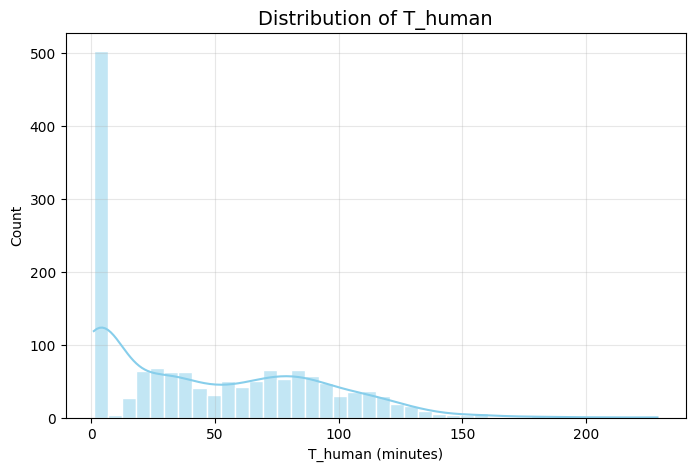

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop missing values for plotting
t_vals = data_df["T_human"].dropna()

plt.figure(figsize=(8, 5))
sns.histplot(t_vals, bins=40, kde=True, color="skyblue", edgecolor="white")
plt.title("Distribution of T_human", fontsize=14)
plt.xlabel("T_human (minutes)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()


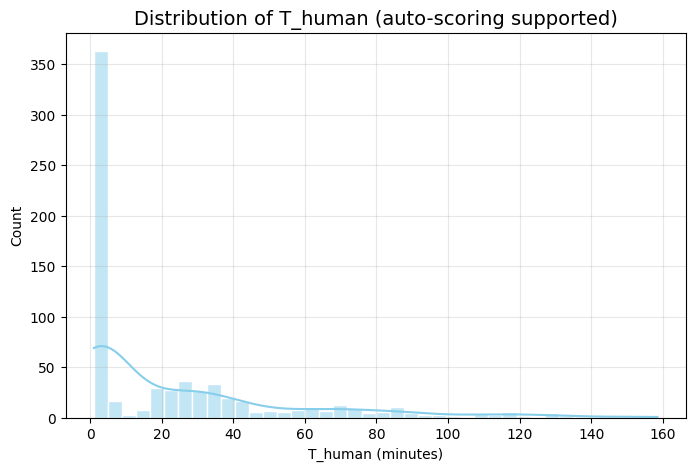

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter valid rows: support_auto_scoring == True and T_human not NaN and is_multiple_answer == False
filtered = data_df[
    (data_df["support_auto_scoring"] != False) & data_df["T_human"].notna() & (data_df["is_multiple_answer"] == False)
]

plt.figure(figsize=(8, 5))
sns.histplot(filtered["T_human"], bins=40, kde=True, color="skyblue", edgecolor="white")
plt.title("Distribution of T_human (auto-scoring supported)", fontsize=14)
plt.xlabel("T_human (minutes)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()


In [21]:
filtered["T_human"].describe()

count    704.000000
mean      24.412666
std       32.106337
min        1.002451
25%        2.275102
50%        4.377574
75%       34.598093
max      158.537402
Name: T_human, dtype: float64

## EXPORT

In [22]:
filtered.to_csv("T_human_English_Olympiad_Mathematics.csv")

## 10 Qs - Upper bounds

In [23]:

# Step 1: Filter valid rows
filtered = data_df[
    (data_df["support_auto_scoring"] != False)
    & (data_df["T_human"].notna())
    & (data_df["is_multiple_answer"] == False)
]

# Step 2: Compute the 90th percentile of T_human
t90 = np.percentile(filtered["T_human"], 90)

# Step 3: Select questions close to that percentile (±5% range)
tolerance = 0.05 * t90
around_90 = filtered[
    (filtered["T_human"] >= t90 - tolerance) & (filtered["T_human"] <= t90 + tolerance)
]

# Step 4: Sample 10 questions (or fewer if not enough)
upper_bound_questions = around_90.sample(n=min(10, len(around_90)), random_state=42)

# Step 5: 
upper_bound_questions.to_csv("upper_bound_questions.csv")

In [30]:
import math
import pandas as pd
import tiktoken
from textwrap import dedent

CSV_PATH = "upper_bound_questions.csv"    
MODEL = "gpt-4o"                        
ENC = tiktoken.encoding_for_model(MODEL)

PRICES = {
    "gpt-4o": {"input": 5/1000000, "output": 15/1000000} # From -> https://openrouter.ai/compare/openai/chatgpt-4o-latest
}

MATH_PROMPT_TEMPLATE = dedent("""
Solve the following math problem step by step. The last line of your
response should be of the form "ANSWER: $ANSWER" (without quotes)
where $ANSWER is the answer to the problem.

{prompt}

Remember to put your answer on its own line at the end in the form
"ANSWER: $ANSWER" (without quotes) where $ANSWER is the answer to
the problem, and you do not need to use a \\boxed command or a \\displaystyle command.
""").strip()

# Precompute fixed template tokens (everything except the {prompt} placeholder)
fixed_template = MATH_PROMPT_TEMPLATE.replace("{prompt}", "")
fixed_template_tokens = len(ENC.encode(fixed_template))

def count_tokens(text: str) -> int:
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)
    return len(ENC.encode(text))

def cost_usd(input_toks: int, output_toks: int, model: str) -> float:
    p = PRICES[model]
    return (input_toks) * p["input"] + (output_toks) * p["output"]

# Load CSV
df = pd.read_csv(CSV_PATH)
assert "question" in df.columns, "CSV must contain a 'question' column."

# Token counts
df["question_tokens"] = df["question"].apply(count_tokens)
df["input_tokens"] = df["question_tokens"] + fixed_template_tokens

# Output estimation
OUTPUT_FACTOR = 1.5
df["output_tokens_estim"] = (df["solution"].apply(count_tokens) * OUTPUT_FACTOR).apply(math.ceil)

# Costs (fill PRICES first to get non-zero values)
df["cost_usd_estim"] = df.apply(
    lambda r: cost_usd(r["input_tokens"], r["output_tokens_estim"], MODEL), axis=1
)

totals = {
    "rows": len(df),
    "fixed_template_tokens": fixed_template_tokens,
    "total_input_tokens": int(df["input_tokens"].sum()),
    "total_output_tokens_estim": int(df["output_tokens_estim"].sum()),
    "grand_total_tokens_estim": int(df["input_tokens"].sum() + df["output_tokens_estim"].sum()),
    "total_cost_usd_estim": float(df["cost_usd_estim"].sum())
}

print("Totals:", totals)

Totals: {'rows': 10, 'fixed_template_tokens': 95, 'total_input_tokens': 2082, 'total_output_tokens_estim': 17958, 'grand_total_tokens_estim': 20040, 'total_cost_usd_estim': 0.27978000000000003}


In [31]:
totals

{'rows': 10,
 'fixed_template_tokens': 95,
 'total_input_tokens': 2082,
 'total_output_tokens_estim': 17958,
 'grand_total_tokens_estim': 20040,
 'total_cost_usd_estim': 0.27978000000000003}